In [ ]:
import torch
import wandb

from src.data.dataset import get_data, base_novel_categories, split_dataset, CLASS_NAMES
from src.models.clip_wrapper import load_clip_model
from src.training.evaluation import eval, linear_probe_evaluation
from src.utils.metrics import harmonic_mean
from src.models.lora import add_lora_to_model
from src.training.trainer import get_optimizer, get_cost_function, training_step
from src.utils.logging import inspect_trainable_parameters, inspect_model_training

In [2]:
torch.autograd.set_detect_anomaly(True)
torch.backends.cuda.enable_flash_sdp(False)

# Fine-tuning using LoRA

Inspiration taken from https://lightning.ai/lightning-ai/studios/code-lora-from-scratch?section=featured


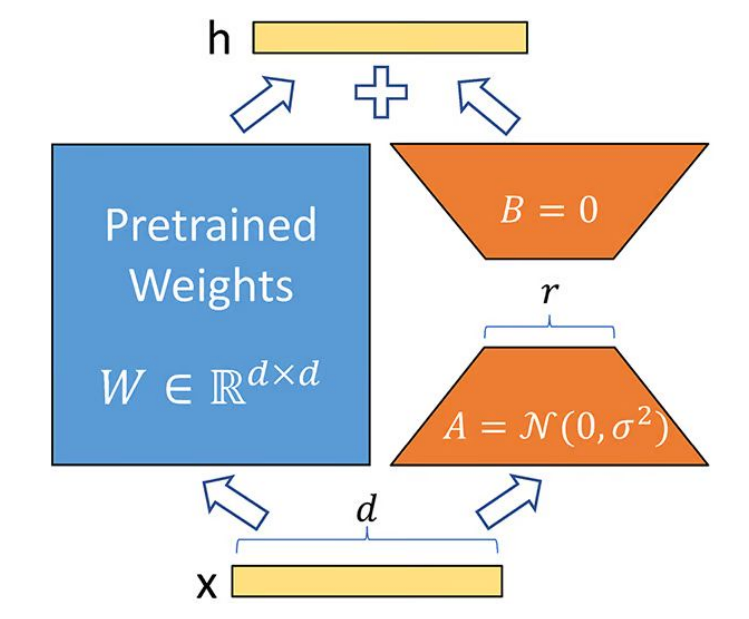

In [3]:
#load clip model
model, preprocess, device = load_clip_model()

#freeze the pretrained network weights
for param in model.parameters():
    param.requires_grad = False

In [4]:
#set parameters for LoRA
rank = 8
alpha = 16

num_params_lora = 0
num_params_full = 0
for name, module in model.visual.named_modules():
    if isinstance(module, torch.nn.Linear):
        num_params_lora += module.in_features * rank + module.out_features *rank
        num_params_full += module.in_features * module.out_features

print("Number of learnable parameters with LoRA with rank {rank}:", num_params_lora)
print("Number of learnable parameters with full fine-tune:", num_params_full)
print(f"LoRA requires {num_params_lora/num_params_full*100:.2f}% parameters compared to full fine-tune")

Number of learnable parameters with LoRA with rank {rank}: 884736
Number of learnable parameters with full fine-tune: 63700992
LoRA requires 1.39% parameters compared to full fine-tune


In [5]:
add_lora_to_model(model.visual, rank=rank, alpha=alpha)

In [6]:
print(model.visual)

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): LinearPlusLora(
            (linear): Linear(in_features=768, out_features=3072, bias=True)
            (lora): LoraLayer()
          )
          (gelu): QuickGELU()
          (c_proj): LinearPlusLora(
            (linear): Linear(in_features=3072, out_features=768, bias=True)
            (lora): LoraLayer()
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
  

## Fine-tune using LoRA

In [ ]:
def main(epochs, batch_size, lr, wd, momentum, rank, alpha):
    #initialize weights and biases logging
    run = wandb.init(project="lora-training", config={
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "weight_decay": wd,
        "momentum": momentum,
        "rank": rank,
        "alpha": alpha
    })

    #load the pretrained model
    model, preprocess, device = load_clip_model()

    #freeze the pretrained model
    for param in model.parameters():
        param.requires_grad = False

    #add LoRA trainable parameters
    add_lora_to_model(model.visual, rank, alpha)

    #ensure that lora layers are not frozen
    for name, param in model.named_parameters():
        if "lora" in name:
            param.requires_grad = True

    inspect_trainable_parameters(model)

    #get datasets
    train_set, val_set, test_set = get_data(transform=preprocess)
    base_classes, novel_classes = base_novel_categories(train_set)
    train_base, train_novel = split_dataset(train_set, base_classes)
    val_base, _ = split_dataset(val_set, base_classes)
    test_base, test_novel = split_dataset(test_set, base_classes)

    #initialize training components
    optimizer = get_optimizer(model, lr, wd, momentum)
    cost_function = get_cost_function()

    #enter training loop
    best_val_acc = 0
    for epoch in range(epochs):
        #train
        model.train()
        train_loss = training_step(
            model=model, 
            dataset=train_base, 
            categories=base_classes, 
            batch_size=batch_size, 
            optimizer=optimizer, 
            cost_function=cost_function, 
            device=device
        )

        #validate
        model.eval()
        with torch.no_grad():
            val_acc = eval(
                model=model,
                dataset=val_base,
                categories=base_classes,
                batch_size=batch_size,
                device=device
            )

        inspect_model_training(model, epoch=epoch, train_loss=train_loss, val_accuracy=val_acc)

        #print progress
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_acc*100:.2f}%")

        #save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            #torch.save(model.state_dict(), "best_model.pt")

    base_accuracy = eval(model=model, dataset=test_base, categories=base_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")
    novel_accuracy = eval(model=model, dataset=test_novel, categories=novel_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Novel Classes")

    print()
    print(f"🔍 Base classes accuracy: {base_accuracy*100:.2f}%")
    print(f"🔍 Novel classes accuracy: {novel_accuracy*100:.2f}%")

    base_separability = linear_probe_evaluation(model, train_base, test_base, batch_size=32)
    novel_separability = linear_probe_evaluation(model, train_novel, test_novel, batch_size=32)

    print(f"Base classes separability in embedding: {base_separability}")
    print(f"Novel classes separability in embedding: {novel_separability}")

    run.finish()
    return model

In [ ]:
#classifying in the embedding space might not be sound, as there is a pretty high imbalance in the number 
#of training x test samples, balancing it could give more reasoned conclusions

In [13]:
main(epochs=10, batch_size=16, lr=1e-3, wd=1e-5, momentum=0.9, rank=8, alpha=1)

100%|██████████| 32/32 [00:01<00:00, 18.11it/s]


Epoch 1/10
Train Loss: 3.7922
Val Accuracy: 69.61%


100%|██████████| 32/32 [00:01<00:00, 18.34it/s]


Epoch 2/10
Train Loss: 3.6772
Val Accuracy: 68.24%


100%|██████████| 32/32 [00:01<00:00, 17.01it/s]


Epoch 3/10
Train Loss: 3.6246
Val Accuracy: 73.14%


100%|██████████| 32/32 [00:01<00:00, 16.80it/s]


Epoch 4/10
Train Loss: 3.5933
Val Accuracy: 74.51%


100%|██████████| 32/32 [00:01<00:00, 16.51it/s]


Epoch 5/10
Train Loss: 3.5690
Val Accuracy: 76.47%


100%|██████████| 32/32 [00:01<00:00, 16.30it/s]


Epoch 6/10
Train Loss: 3.5490
Val Accuracy: 79.41%


100%|██████████| 32/32 [00:02<00:00, 14.59it/s]


Epoch 7/10
Train Loss: 3.5316
Val Accuracy: 81.18%


100%|██████████| 32/32 [00:02<00:00, 14.46it/s]


Epoch 8/10
Train Loss: 3.5166
Val Accuracy: 84.12%


100%|██████████| 32/32 [00:02<00:00, 15.25it/s]


Epoch 9/10
Train Loss: 3.5021
Val Accuracy: 86.08%


100%|██████████| 32/32 [00:02<00:00, 14.71it/s]


Epoch 10/10
Train Loss: 3.4899
Val Accuracy: 84.12%


🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]



🔍 Base classes accuracy: 79.78%
🔍 Novel classes accuracy: 52.99%


🖼️Extracting features of test set: 100%|██████████| 115/115 [00:12<00:00,  8.92it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Base classes separability in embedding: 95.2689041649818
Novel classes separability in embedding: 93.19912948857454


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuarcy,▂▁▃▃▄▅▆▇█▇
epoch,9
train_loss,3.48993
val_accuarcy,0.84118


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): LinearPlusLora(
              (linear): Linear(in_features=768, out_features=3072, bias=True)
              (lora): LoraLayer()
            )
            (gelu): QuickGELU()
            (c_proj): LinearPlusLora(
              (linear): Linear(in_features=3072, out_features=768, bias=True)
              (lora): LoraLayer()
            )
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1)